In [17]:
import matplotlib.pyplot as plt
import networkx as nx
import community.community_louvain as community_louvain  # Explicit import to avoid conflicts
from collections import defaultdict
import random
import os
import random
from collections import defaultdict, Counter
from community import community_louvain
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [34]:
import networkx as nx
from collections import defaultdict
import random
from community import community_louvain  # Install via `pip install python-louvain`

# Define the path to the GEXF file
file_path = r'./../networks/One_Piece.gexf'  # Replace with the actual path to your file

# Load the graph from the GEXF file
G = nx.read_gexf(file_path)

# Set random seed for reproducibility
random.seed(42)

# Perform Louvain community detection
louvain_partition = community_louvain.best_partition(G, resolution=1)

# Group nodes by their community
communities_louvain = defaultdict(list)
for node, community in louvain_partition.items():
    communities_louvain[community].append(node)

# Sort communities by the size (number of nodes) in descending order
sorted_communities = sorted(communities_louvain.items(), key=lambda x: len(x[1]), reverse=True)

# Output the results
print(f"Number of Communities: {len(sorted_communities)}")
print("Communities sorted by size:")
for i, (community_id, nodes) in enumerate(sorted_communities, 1):
    print(f"- Community {i} (ID: {community_id}): {len(nodes)} nodes")


Number of Communities: 121
Communities sorted by size:
- Community 1 (ID: 2): 137 nodes
- Community 2 (ID: 11): 136 nodes
- Community 3 (ID: 90): 105 nodes
- Community 4 (ID: 8): 88 nodes
- Community 5 (ID: 10): 88 nodes
- Community 6 (ID: 66): 78 nodes
- Community 7 (ID: 13): 76 nodes
- Community 8 (ID: 32): 70 nodes
- Community 9 (ID: 24): 15 nodes
- Community 10 (ID: 0): 10 nodes
- Community 11 (ID: 22): 10 nodes
- Community 12 (ID: 15): 8 nodes
- Community 13 (ID: 76): 8 nodes
- Community 14 (ID: 4): 6 nodes
- Community 15 (ID: 23): 6 nodes
- Community 16 (ID: 81): 6 nodes
- Community 17 (ID: 83): 5 nodes
- Community 18 (ID: 106): 5 nodes
- Community 19 (ID: 25): 4 nodes
- Community 20 (ID: 42): 4 nodes
- Community 21 (ID: 53): 4 nodes
- Community 22 (ID: 58): 4 nodes
- Community 23 (ID: 3): 3 nodes
- Community 24 (ID: 35): 3 nodes
- Community 25 (ID: 37): 3 nodes
- Community 26 (ID: 40): 3 nodes
- Community 27 (ID: 47): 3 nodes
- Community 28 (ID: 71): 3 nodes
- Community 29 (ID: 

In [32]:
# cleaning the text

# Function to lemmatize each word based on its part of speech
def lemmatize_word(word):
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(word)

# Function to process the content text
def process_text(content, lemmatize=False):
    # Tokenize the content into individual words
    tokens = word_tokenize(content)
    
    # Remove punctuation and convert to lower case
    tokens = [word.lower() for word in tokens if word.isalpha()]
    
    # Lemmatize the tokens if required
    if lemmatize:
        tokens = [lemmatize_word(word) for word in tokens]
    
    # Filter out rare words that appear less than 5 times
    token_counts = Counter(tokens)
    tokens = [word for word in tokens if token_counts[word] >= 5]

    # Filter out stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    return tokens

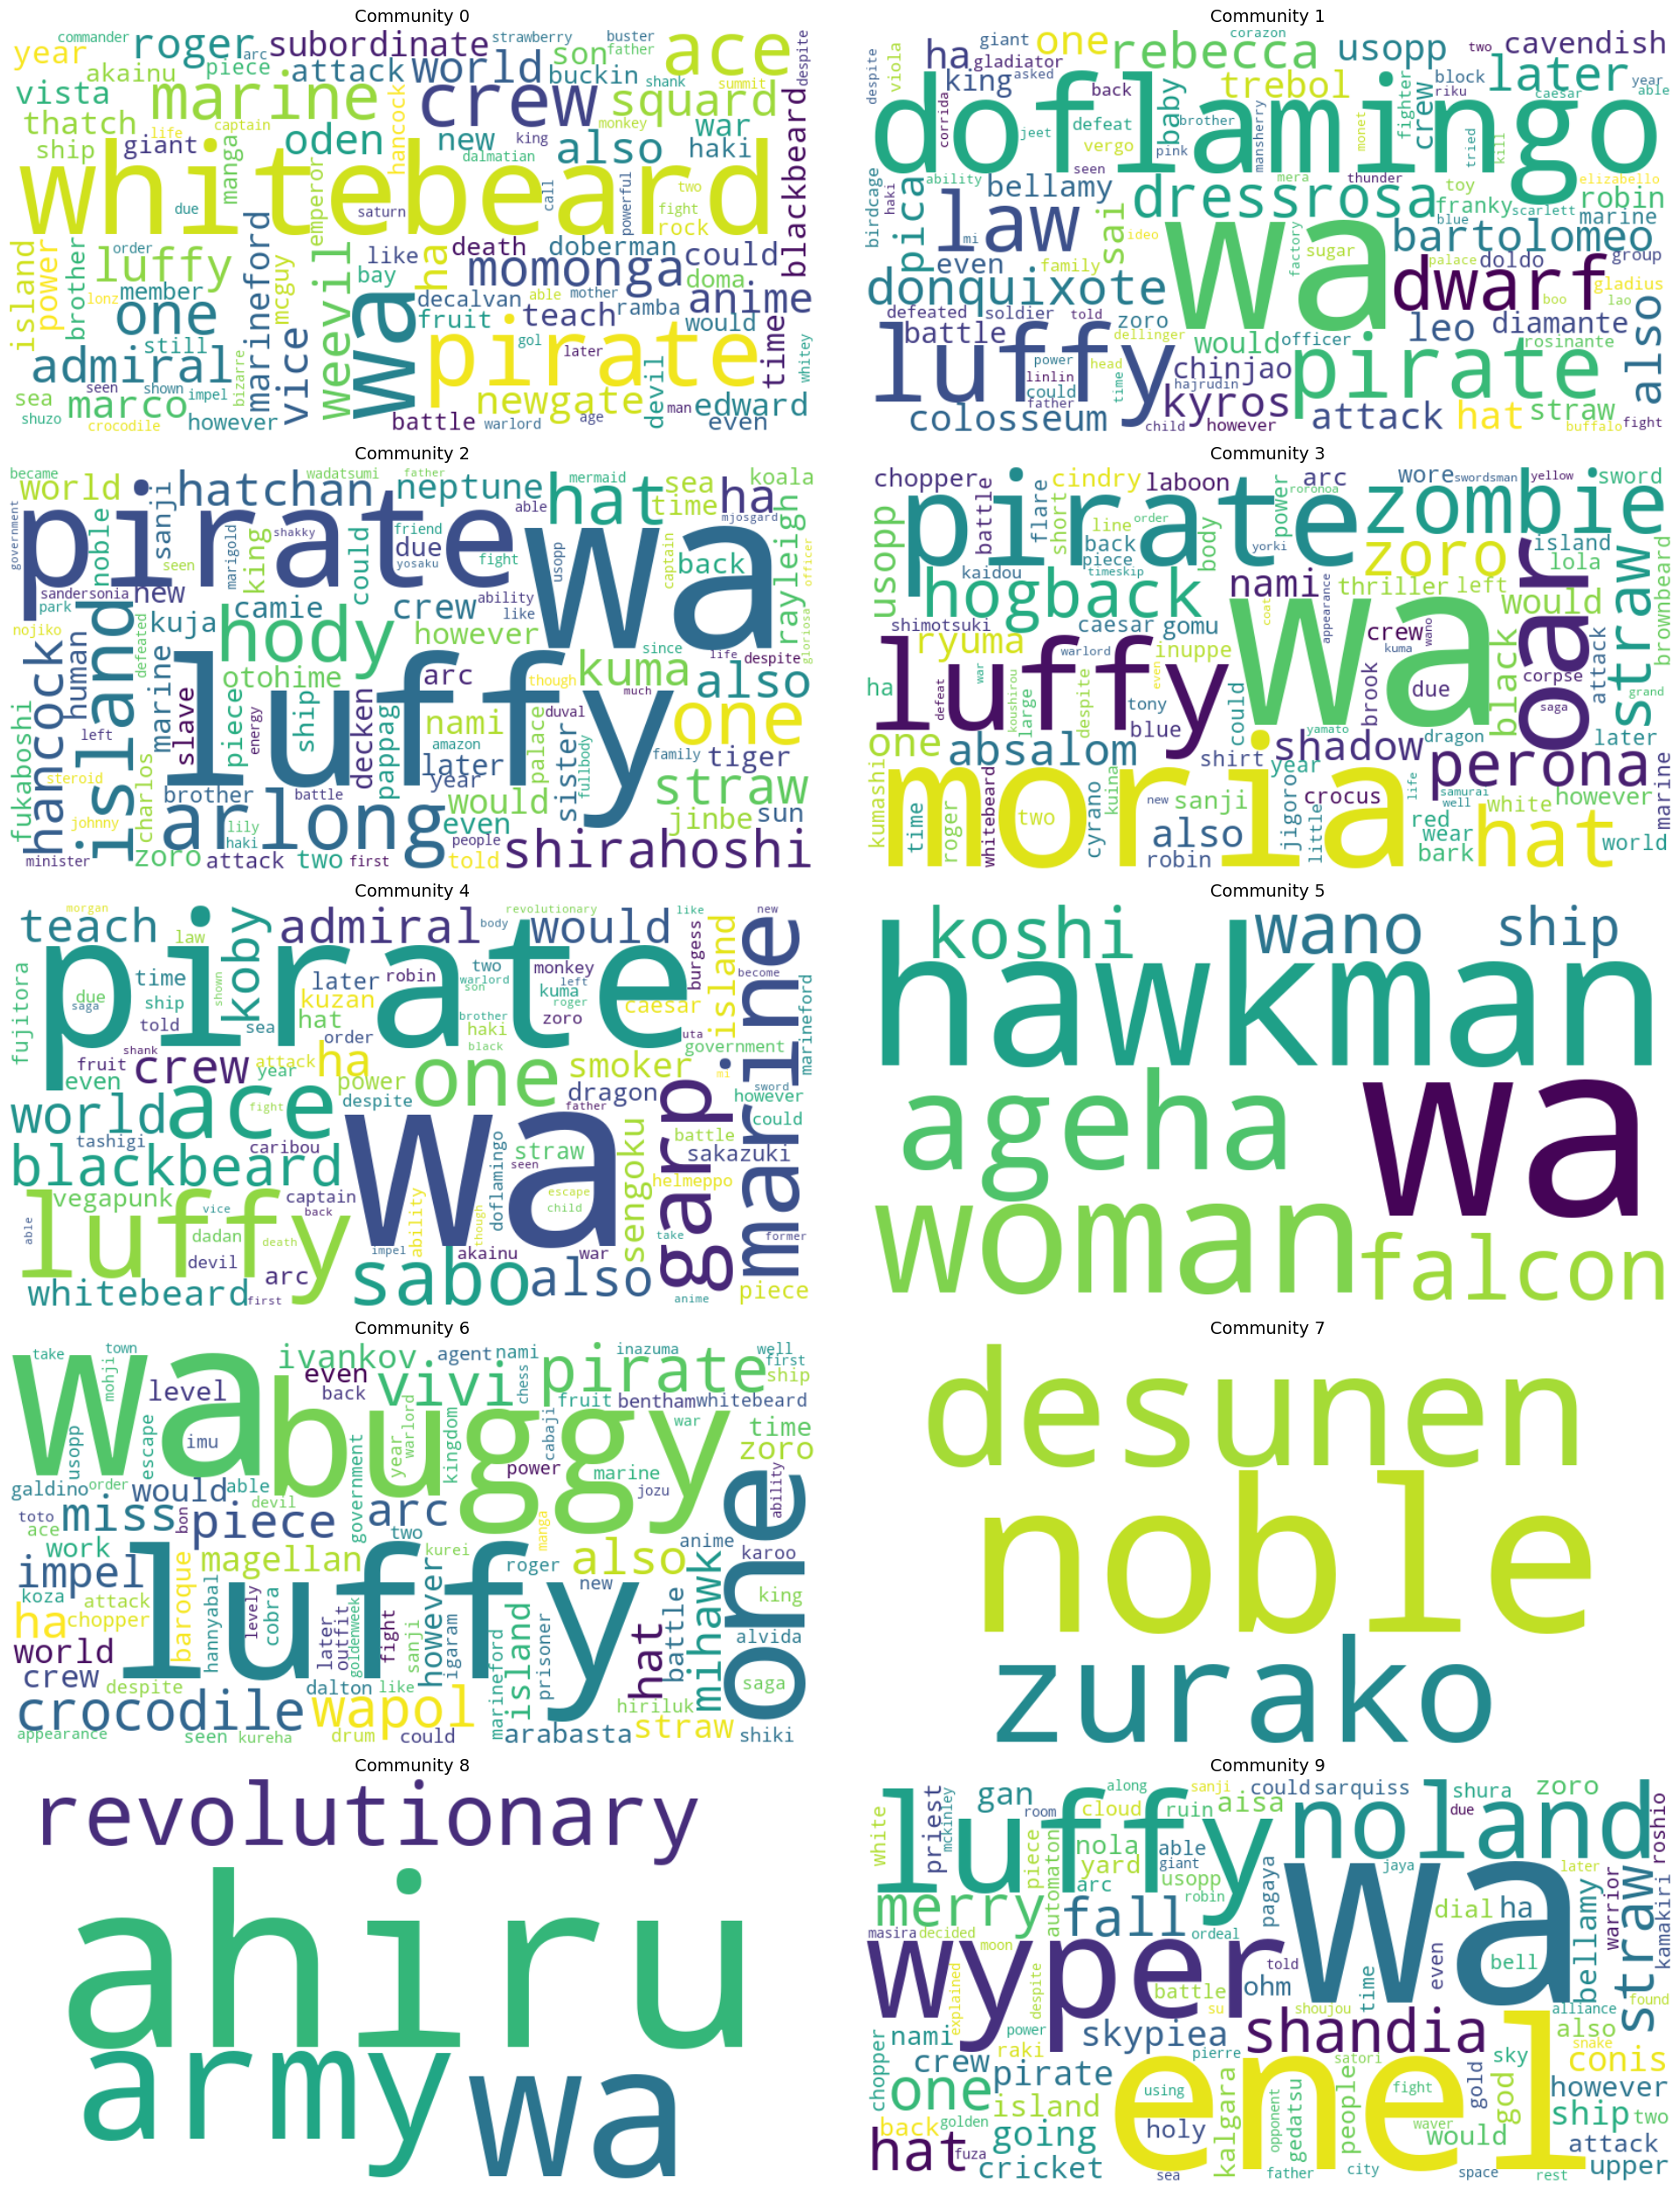

In [33]:
text_dir = r"./../onepiece_cleaned"  # Replace with your actual directory path

# Prepare content for each community
communities_content = {}
for community, members in communities_louvain.items():
    communities_content[community] = []
    for node in members:
        filename = os.path.join(text_dir, f"{node}.txt")
        if os.path.exists(filename):
            # Read and clean the content of each file
            with open(filename, 'r', encoding='utf-8') as file:
                raw_content = file.read()
                cleaned_content = " ".join(process_text(raw_content, lemmatize=True))
                communities_content[community].append(cleaned_content)

# Prepare word clouds for up to 10 communities
fig, axes = plt.subplots(5, 2, figsize=(20, 25))  # Create a 5x2 grid for subplots
axes = axes.flatten()

# Generate word clouds
for i, (community, contents) in enumerate(communities_content.items()):
    if i >= 10:  # Limit to 10 communities
        break
    
    # Merge all text content in the community
    merged_content = " ".join(contents)
    
    # Perform TF-IDF analysis
    vectorizer = TfidfVectorizer(max_features=100)  # Limit to top 100 features
    X = vectorizer.fit_transform([merged_content])
    tfidf_scores = dict(zip(vectorizer.get_feature_names_out(), X.toarray().flatten()))
    
    # Create a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(tfidf_scores)
    
    # Plot the word cloud in the corresponding subplot
    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Community {community}", fontsize=14)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()